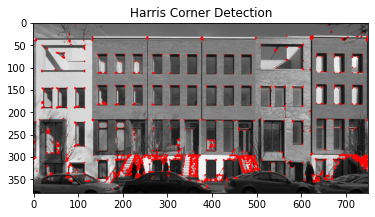

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_corner_detection(image_path, threshold=0.01):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Compute gradients using Sobel operator
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of gradients
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Apply Gaussian window on products of gradients
    sigma = 1
    k = 0.04
    size = int(6 * sigma)
    if size % 2 == 0:
        size += 1

    gaussian = cv2.getGaussianKernel(size, sigma)
    W = np.outer(gaussian, gaussian.transpose())

    Ixx = cv2.filter2D(Ixx, -1, W)
    Iyy = cv2.filter2D(Iyy, -1, W)
    Ixy = cv2.filter2D(Ixy, -1, W)

    # Compute Harris response function
    det_M = Ixx * Iyy - Ixy ** 2
    trace_M = Ixx + Iyy
    R = det_M - k * (trace_M ** 2)

    # Thresholding
    corners = np.where(R > threshold * R.max())

    # Display the result
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img_color[corners] = [0, 0, 255]  # Mark corners in red

    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title('Harris Corner Detection')
    plt.show()
    
    cv2.imshow("Harris Corner Detection", img_color)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image_path = 'building.jpg'
harris_corner_detection(image_path)

In [109]:
def sift_matching(image1_path, image2_path):
    # Load the images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    

    # Brute Force Matcher
    bf = cv2.BFMatcher()

    # Match descriptors using KNN (k-nearest neighbors)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    threshold=0.25
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)
            

    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the matches
    plt.imshow(img_matches)
    plt.title('SIFT Matches')
    plt.show()
    
    cv2.namedWindow("Sift_Matches", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Sift_Matches", 2000, 1000)
    cv2.imshow("Sift_Matches", img_matches)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

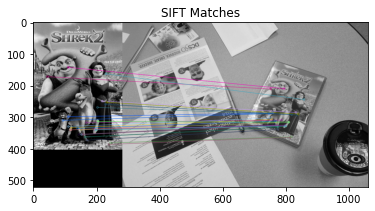

In [110]:
image1_path = 'reference.png'
image2_path = 'test.png'
sift_matching(image1_path, image2_path)  # Adjust the threshold as needed

In [ ]:
def drawkeypoints(image1):
    # Load the images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, _ = sift.detectAndCompute(img1, None)
    
    # only draw first 100
    kp_trimmed = keypoints1[:100]

    img_kp = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    for k in kp_trimmed:
        img_kp = cv2.circle(img_kp, (int(k.pt[0]), int(k.pt[1])), int(k.size), [0, 255, 0])

    cv2.namedWindow("Sift_Matches", cv2.WINDOW_NORMAL)
    # cv2.resizeWindow("Sift_Matches", 2000, 1000)
    cv2.imshow("Sift_Matches", img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image1_path = 'test2.png'
image2_path = 'test.png'

In [584]:
def get_top_matches(image1, image2):
    # Load the images
    img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    # Brute Force Matcher
    bf = cv2.BFMatcher()

    # Match descriptors using KNN (k-nearest neighbors)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # get best matches
    tempMatches = {}
    for m, n in matches:
        # store values in dict, keys => distance values => corresponding DMatch
        distance = n.distance - m.distance
        tempMatches[distance] = m
    # decided to go from 3 matches to 5+ to increase the accuracy of the future homography matrix
    top_three = sorted(np.fromiter(tempMatches.keys(), float))[-10:]
    worst_three = sorted(np.fromiter(tempMatches.keys(), float))[:3]
    
    good_matches = []
    for i in range(len(top_three)):
        good_matches.append(tempMatches[top_three[i]])
    # Testing to see what worst 3 matches look like
    bad_matches = [tempMatches[worst_three[0]], tempMatches[worst_three[1]], tempMatches[worst_three[2]]]

    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the matches
    # cv2.namedWindow("Sift_Matches", cv2.WINDOW_NORMAL)
    # cv2.resizeWindow("Sift_Matches", 2000, 1000)
    # cv2.imshow("Sift_Matches", img_matches)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    

    return good_matches, keypoints1, keypoints2
    


In [585]:
def draw_triangle(image1, image2, matches, keypoints1, keypoints2):
    # Load the images
    img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    
    # get points from matches
    p1, p2, p3 = (keypoints1[matches[0].queryIdx].pt, keypoints1[matches[1].queryIdx].pt, keypoints1[matches[2].queryIdx].pt)
    q1, q2, q3 = (keypoints2[matches[0].trainIdx].pt, keypoints2[matches[1].trainIdx].pt, keypoints2[matches[2].trainIdx].pt)
    # convert float tuple to int tuple
    p1, p2, p3 = tuple(map(int, p1)), tuple(map(int, p2)), tuple(map(int, p3))
    q1, q2, q3 = tuple(map(int, q1)), tuple(map(int, q2)), tuple(map(int, q3))
    
    cv2.line(img1, p1, p2, (255, 0, 0), 3)
    cv2.line(img1, p2, p3, (255, 0, 0), 3)
    cv2.line(img1, p1, p3, (255, 0, 0), 3)

    cv2.line(img2, q1, q2, (255, 0, 0), 3)
    cv2.line(img2, q2, q3, (255, 0, 0), 3)
    cv2.line(img2, q1, q3, (255, 0, 0), 3)
    
    cv2.imshow("image1", img1)
    cv2.imshow("image2", img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [589]:
def get_affine_transformation(image1, image2, matches, keypoints1, keypoints2):

    # Load the images
    img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    # pull points for the first 3 values (to draw a triangle) from keypoints
    p1, p2, p3 = (keypoints1[matches[0].queryIdx].pt, keypoints1[matches[1].queryIdx].pt, keypoints1[matches[2].queryIdx].pt)
    q1, q2, q3 = (keypoints2[matches[0].trainIdx].pt, keypoints2[matches[1].trainIdx].pt, keypoints2[matches[2].trainIdx].pt)

    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    _x1, _y1 = q1
    _x2, _y2 = q2
    _x3, _y3 = q3
    
    # construct the H matrix
    H = [[x1, y1, 1, 0, 0, 0, -_x1*x1, -_x1*y1, -_x1],
         [0, 0, 0, x1, y1, 1, -_y1*x1, -_y1*y1, -_y1],
         [x2, y2, 1, 0, 0, 0, -_x2*x2, -_x2*y2, -_x2],
         [0, 0, 0, x2, y2, 1, -_y2*x2, -_y2*y2, -_y2],
         [x3, y3, 1, 0, 0, 0, -_x3*x3, -_x3*y3, -_x3],
         [0, 0, 0, x3, y3, 1, -_y3*x3, -_y3*y3, -_y3]]


    # use the rest of points to help make the homography matrix stronger but not add to visual aspect
    for ind in range(3, len(matches)):
        p = keypoints1[matches[ind].queryIdx].pt
        q = keypoints2[matches[ind].trainIdx].pt
        x, y = p
        _x, _y = q
        h_part1, h_part2 = [x, y, 1, 0, 0, 0, -_x*x, -_x*y, -_x], [0, 0, 0, x, y, 1, -_y*x, -_y*y, -_y]
        H.append(h_part1)
        H.append(h_part2)
    
    _, _, V = np.linalg.svd(H)
    h = V[-1].reshape(3, 3)
    
    # functions for getting prime values of x and y
    x_prime = lambda x, y, h1: (h1[0][0] * x + h1[0][1] * y + h1[0][2]) / (h1[2][0] * x + h1[2][1] * y + h1[2][2])
    y_prime = lambda x, y, h1: (h1[1][0] * x + h1[1][1] * y + h1[1][2]) / (h1[2][0] * x + h1[2][1] * y + h1[2][2])
    
    # getting triangle points from img1 via homography
    _p1 = (int(x_prime(x1, y1, h)), int(y_prime(x1, y1, h)))
    _p2 = (int(x_prime(x2, y2, h)), int(y_prime(x2, y2, h)))
    _p3 = (int(x_prime(x3, y3, h)), int(y_prime(x3, y3, h)))
    p1, p2, p3 = tuple(map(int, p1)), tuple(map(int, p2)), tuple(map(int, p3))


    # getting points for border of reference image via homography matrix
    img_y, img_x = img1.shape
    _tl = (int(x_prime(0, 0, h)), int(y_prime(0, 0, h)))
    tl = (0, 0)

    _tr = (int(x_prime(img_x, 0, h)), int(y_prime(img_x, 0, h)))
    tr = (img_x, 0)

    _bl = (int(x_prime(0, img_y, h)), int(y_prime(0, img_y, h)))
    bl = (0, img_y)

    _br = (int(x_prime(img_x, img_y, h)), int(y_prime(img_x, img_y, h)))
    br = (img_x, img_y)
    
    
    # draw border on reference
    cv2.line(img1, tl, tr, (255, 0, 0), 3)
    cv2.line(img1, tr, br, (255, 0, 0), 3)
    cv2.line(img1, tl, bl, (255, 0, 0), 3)
    cv2.line(img1, bl, br, (255, 0, 0), 3)
    
    # draw reference border on img2
    cv2.line(img2, _tl, _tr, (255, 0, 0), 3)
    cv2.line(img2, _tr, _br, (255, 0, 0), 3)
    cv2.line(img2, _tl, _bl, (255, 0, 0), 3)
    cv2.line(img2, _bl, _br, (255, 0, 0), 3)
    
    # draw triangle in reference
    cv2.line(img1, p1, p2, (255, 0, 0), 3)
    cv2.line(img1, p2, p3, (255, 0, 0), 3)
    cv2.line(img1, p3, p1, (255, 0, 0), 3)

    # draw triangle from reference with homography matrix
    cv2.line(img2, _p1, _p2, (255, 0, 0), 3)
    cv2.line(img2, _p2, _p3, (255, 0, 0), 3)
    cv2.line(img2, _p3, _p1, (255, 0, 0), 3)

    cv2.imshow("image1", img1)
    cv2.imshow("image2", img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    
    return h

In [590]:
image1_path = 'reference.png'
image2_path = 'test.png'
best_matches, kp1, kp2  = get_top_matches(image1_path, image2_path)
# draw_triangle(image1_path, image2_path, best_matches, kp1, kp2)
h = get_affine_transformation(image1_path, image2_path, best_matches, kp1, kp2)